將新聞文章分類到預定義的類別（例如科技、政治、商業、娛樂和體育）是自然語言處理 (NLP) 中的一項任務。本專案探討與評估不同機器學習方法，包括非監督式學習的矩陣分解 (Matrix Factorization) 及監督式學習中的支援向量機 (Support Vector Machine)和邏輯斯迴歸 (Logistic Regression)方法，來達成新聞文章的分類。

資料敘述：使用來自 Kaggle 的 BBC 公開數據集，其中包含 2225 篇新聞文章，每篇文章都被標記為以下 5 個類別之一：

- business（商業）
- entertainment（娛樂）
- politics（政治）
- sport（體育）
- tech（科技）

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [60]:
import nltk.corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:
# 文字前處理（Text Preprocessing）
from nltk.corpus import stopwords  # 停用字詞（stopwords）清單
from nltk.stem import PorterStemmer  # 詞幹提取（Stemming）

In [62]:
import itertools  # 高效迴圈工具（排列組合等）
from collections import Counter  # 計算元素出現次數
from string import punctuation  # 標點符號清單（常用於去除標點）

In [63]:
# 特徵工程（Feature Engineering）
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF 向量化
from sklearn.decomposition import NMF, TruncatedSVD  # 主題建模與降維
from sklearn.preprocessing import Normalizer  # 特徵標準化（L2 norm）

In [64]:
# 模型訓練與選擇（Modeling）
from sklearn.model_selection import train_test_split, GridSearchCV  # 資料切分與超參數調整
from sklearn.linear_model import LogisticRegression  # 邏輯回歸分類器
from sklearn.svm import SVC  # 支援向量機（SVM）分類器
from sklearn.pipeline import Pipeline  # 串接處理流程（pipeline）

In [65]:
# 評估與視覺化（Evaluation & Visualization）
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay  # 評估指標與視覺化
from wordcloud import WordCloud  # 文字雲圖產生器
from tqdm import tqdm  # 美化迴圈進度顯示

In [66]:
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv("/content/drive/MyDrive/BBC News Train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/BBC News Test.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 探索性資料分析與資料前處理

In [67]:
train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [69]:
print(f'Number of train dataset rows: {train_data.shape[0]}, columns: {train_data.shape[1]}')
print(f'Number of test dataset rows: {test_data.shape[0]}, columns: {test_data.shape[1]}')

Number of train dataset rows: 1490, columns: 3
Number of test dataset rows: 735, columns: 2


In [70]:
train_data.isnull().sum()

,0
ArticleId,0
Text,0
Category,0


In [71]:
def plot_categories_distribution(df):
    category_order = df['Category'].value_counts().index
    sns.countplot(x='Category', data=df, order=category_order, color='salmon')
    plt.title('Distribution of Categories in News Articles', fontsize=16)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Number of Articles', fontsize=12)
    plt.xticks()
    plt.tight_layout()
    plt.show()


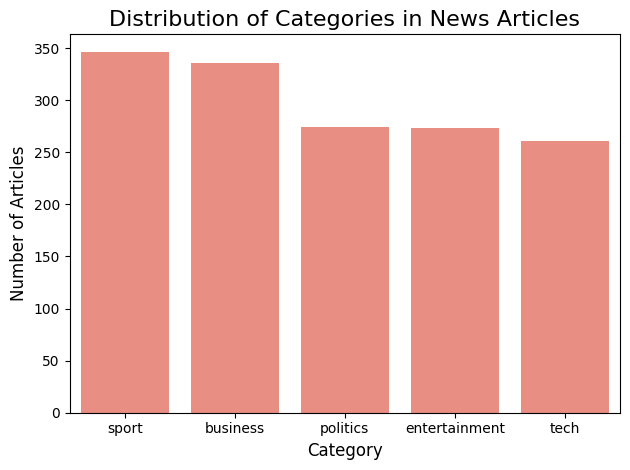

In [72]:
plot_categories_distribution(train_data)

將所有 `Text` 欄位中所有重複的列都保留列，把這些重複的文字依照字母順序排序。

In [73]:
duplicates = train_data[train_data.duplicated(subset=['Text'], keep=False)].sort_values(by='Text')
duplicates

,ArticleId,Text,Category
494,1326,ask jeeves joins web log market ask jeeves has...,tech
228,1098,ask jeeves joins web log market ask jeeves has...,tech
1430,1042,aviator creator in oscars snub the man who s...,entertainment
695,374,aviator creator in oscars snub the man who s...,entertainment
443,1847,blind student hears in colour a blind studen...,tech
...,...,...,...
1047,789,virus poses as christmas e-mail security firms...,tech
1409,957,web radio takes spanish rap global spin the ra...,tech
616,110,web radio takes spanish rap global spin the ra...,tech
63,2017,what high-definition will do to dvds first it ...,tech


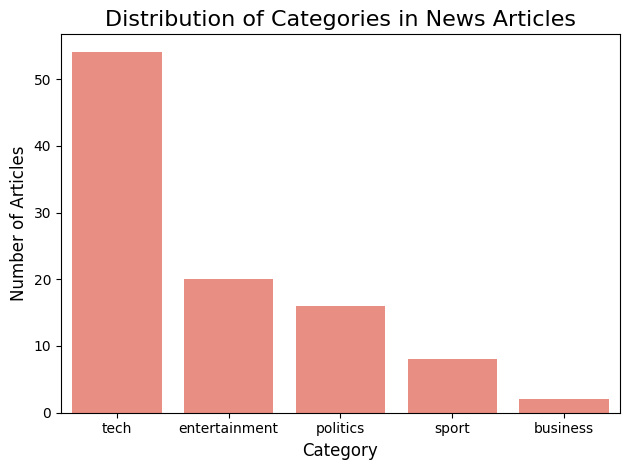

In [74]:
plot_categories_distribution(duplicates)

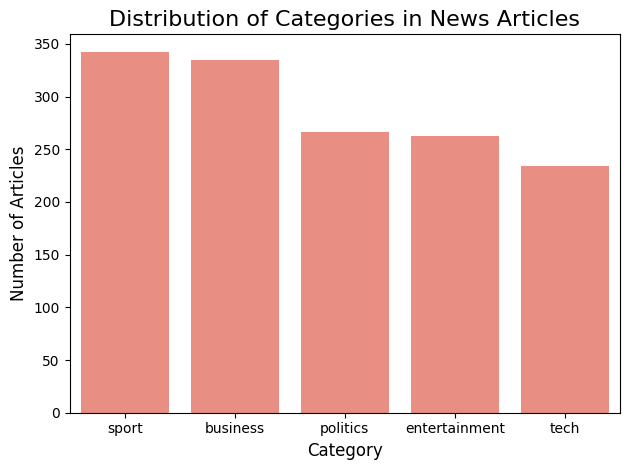

In [75]:
train_data = train_data.drop_duplicates(subset=['Text'])
plot_categories_distribution(train_data)

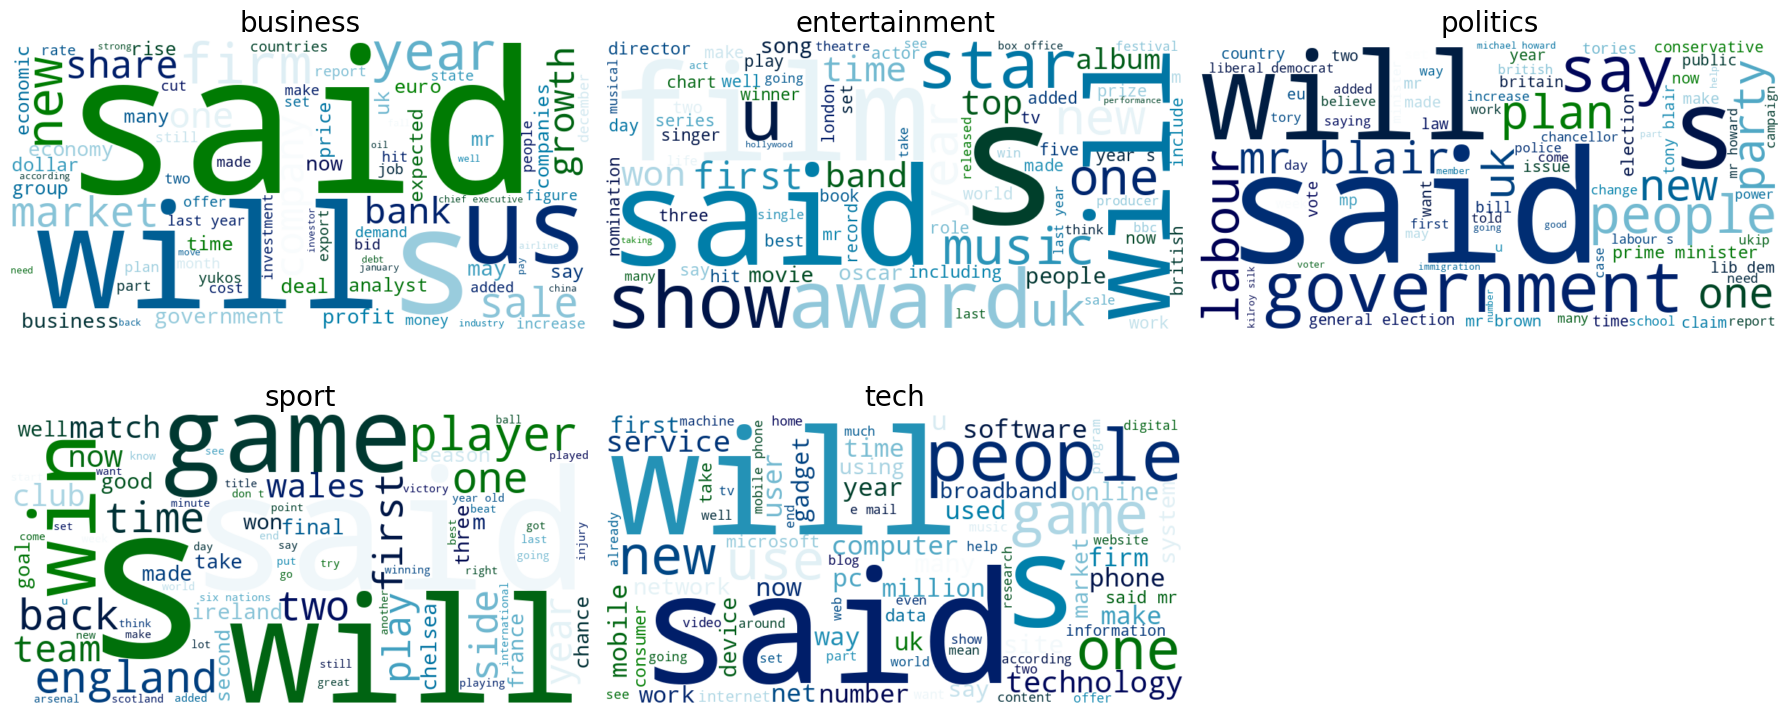

In [76]:
grouped_text = train_data.groupby('Category')['Text'].apply(lambda x: ' '.join(x))

def plot_wordcloud(category, text, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='ocean', max_words=80).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{category}", fontsize=20)
    ax.axis('off')

num_categories = len(grouped_text)
cols = 3
rows = math.ceil(num_categories / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for idx, (category, text) in enumerate(grouped_text.items()):
    plot_wordcloud(category, text, axes[idx])

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


共同詞彙：
在所有新聞分類中，**said（表示）**和 **will（將)** 是最常出現的詞彙，顯示它們在新聞報導和未來事件描述中的普遍使用。

- 商業（Business）：
常見詞彙如 market（市場）、company（公司） 和 share（股份），反映出此類新聞主要關注企業活動與財經動態。

- 娛樂（Entertainment）：
出現頻率高的詞彙包括 film（電影）、music（音樂）、show（節目） 以及 star（明星），突顯出與電影、音樂和名人有關的主題。

- 政治（Politics）：
像是 「blair（布萊爾）」、「people（人民）」 和 「party（政黨）」 等詞，顯示該類新聞主要討論政治人物與選舉議題。

- 體育（Sport）：
詞彙如 「win（勝利）」、「game（比賽）」 和 「player（選手）」，凸顯出體育新聞的焦點多集中於賽事、選手與比賽結果。

- 科技（Tech）：
例如 「use（使用）」、「people（人們）」、「new（新）」 以及 「game（遊戲）」 等詞，反映出科技類新聞著重於技術應用、創新與數位娛樂。

Text(0, 0.5, 'Article Length')

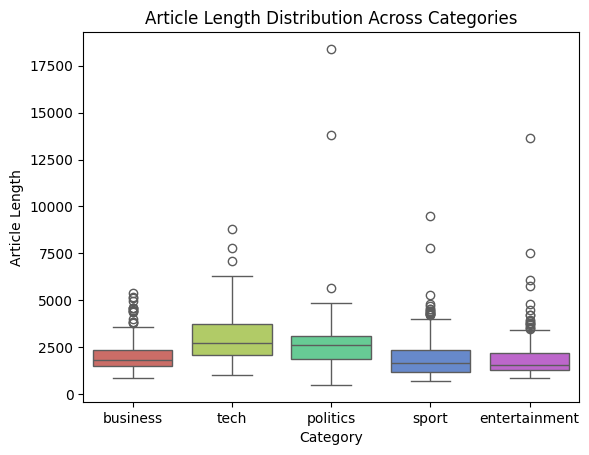

In [77]:
train_data['article_length'] = train_data['Text'].apply(len)
sns.boxplot(data=train_data, x='Category', y='article_length', hue='Category', palette='hls', legend=False)
plt.title('Article Length Distribution Across Categories')
plt.xlabel('Category')
plt.ylabel('Article Length')

由以上盒型圖可以看出**Tech** 和 **politics** 的文章長度相較於其他類別來的長。

文本前處理（Text Preprocessing）

- 全部轉為小寫（Lowercasing）
將所有文字轉為小寫，避免「Tech」與「tech」被當成不同詞處理。

- 移除標點符號與空字串（Remove punctuation and empty strings）
標點通常沒有實質語意，去除可以減少雜訊。

- 詞幹還原（Stemming）
將詞語還原為詞幹，例如「running」→「run」。

- 移除停用詞（Stop Word Removal）
停用詞如 "the", "is", "and" 對文本意義貢獻小，可移除。

In [78]:
def pre_process(df):
    stopwords_set = set(stopwords.words("english"))
    ps = PorterStemmer()

    def process_text(text):
        # convert to lowercase
        text = text.lower()
        # 移除標點符號
        text = ''.join([c for c in text if c not in punctuation])
        # 分割字詞，並移除停用詞與進行詞幹處理
        text = ' '.join([ps.stem(word) for word in text.split() if word not in stopwords_set])
        return text

    # Apply preprocessing to the 'Text' column and store the results
    return df['Text'].apply(process_text)


In [79]:
train_data['Text_Preprocess'] = pre_process(train_data)
test_data['Text_Preprocess'] = pre_process(test_data)

In [80]:
print('Phrase before pre-processing: ', train_data['Text'][0])
print('Phrase after pre-processing: ', train_data['Text_Preprocess'][0])

Phrase before pre-processing:  worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and prac

TF-IDF（Term Frequency-Inverse Document Frequency）是文本處理中常見的特徵提取方法，能夠有效地將原始文本轉換成數值特徵向量。

- Term Frequency (TF): 計算某個詞在文件中的出現頻率。這有助於衡量某個詞對該文件的重要性

- Inverse Document Frequency (IDF): 衡量某個詞在整個語料庫中的罕見程度。當某個詞出現在很多文件中時，它的重要性會降低，反之則增加。

TF-IDF的優點
- 降維（Dimensionality Reduction）：TF-IDF能有效過濾掉一些不太有用的常見詞（如停用詞），從而降低數據的維度，減少雜訊。

- 加權表示（Weighted Representation）：常見但無信息的詞（例如停用詞）會被減少權重，而較少見但對文本意義較為重要的詞會被提高權重。

- 稀疏性（Sparsity）：TF-IDF生成的矩陣通常是稀疏矩陣，這樣可以更高效地用於機器學習模型，特別是線性分類器如SVM或矩陣分解技術。

In [107]:
X = train_data['Text_Preprocess']
y = train_data['Category']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_full = pd.concat([train_data['Text_Preprocess'], test_data['Text_Preprocess']])
y_full = pd.concat([y, pd.Series(["unknown"] * test_data['Text_Preprocess'].shape[0])])

非負矩陣分解（NMF, Non-negative Matrix Factorization）
NMF 是一種常見的降維技術，它將原始的非負矩陣分解為兩個低階的非負矩陣。NMF 將輸入矩陣 V 分解為兩個矩陣：
$$ V \approx WH $$
W：基底矩陣（topics）

H：係數矩陣（每篇文章在各 topic 上的表現）

🔹 特點：

適用於文本資料中的主題建模（Topic Modeling）
所有值都為非負，因此容易解釋：每篇文章是多個主題的加權組合

截斷奇異值分解（Truncated SVD, 又稱為 LSA）

Truncated SVD 是另一種降維方法，透過保留部分奇異值來近似原始矩陣，特別適合處理稀疏矩陣（例如文字的TF-IDF矩陣）。

🔹 特點：

不需要非負性（可以有正值和負值）
保留最重要的結構資訊
常用於文字語義分析，例如 LSA（潛在語義分析）

In [108]:
def topic_mapping_accuracy(estimator, X, y_true):
    # Transform the input data using the fitted estimator
    pred = estimator.transform(X_val)
    y_pred = np.argmax(pred, axis=1)

    # Define the topic mapping
    topic_mapping = {}

    # n_components = 5
    for topic in range(5):
        topic_docs_labels = y_val[y_pred == topic]
        most_common_label = Counter(topic_docs_labels).most_common(1)[0][0]
        topic_mapping[topic] = most_common_label

    y_pred = [topic_mapping[topic] for topic in y_pred]

    # Calculate accuracy
    return accuracy_score(y_val, y_pred)


In [109]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('dim_reduction', NMF()),  # 或 TruncatedSVD()
])


In [110]:
# Define the parameter grid for both NMF and LSA
param_grid = [
    {
        'tfidf__max_df': [0.8, 1.0],   #控制忽略太常見或太少見的詞彙
        'tfidf__min_df': [1, 2, 5],
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  #使用 uni-gram, bi-gram 或 tri-gram
        'tfidf__lowercase': [True],
        'dim_reduction': [NMF(n_components=5, random_state=42)],
        'dim_reduction__solver': ['mu'],       #使用 multiplicative update 演算法
        'dim_reduction__beta_loss': ['kullback-leibler'],   #使用 KL 散度做為 loss function，常見於 topic modeling
        'dim_reduction__init': ['nndsvda','nndsvdar']
    },
    {
        'tfidf__max_df': [0.8, 1.0],
        'tfidf__min_df': [1, 2, 5],
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__lowercase': [True],
        'dim_reduction': [TruncatedSVD(n_components=5)],
        'dim_reduction__algorithm': ['randomized']  #使用隨機演算法來加速分解過程
    }
]

不同的資料量（10%、20%、50%、100%）下進行 GridSearchCV 超參數搜尋，

In [111]:
results = []

# Define percentages of training data to use
percentages = [0.1, 0.2, 0.5, 1.0]

for pct in percentages:
    print(f"Training with {int(pct * 100)}% of the data...")

    # Create a subset of the training data
    if pct == 1.0:
        X_subset, y_subset = X_full, y_full
    else:
        X_subset, _, y_subset, _ = train_test_split(X_full, y_full, train_size=pct, stratify=y_full, random_state=42)

    # Grid search on the subset
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=topic_mapping_accuracy,
        cv=3,  # 3-fold cross-validation
        verbose=1
    )
    grid_search.fit(X_subset, y_subset)

    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    cv_results_df['percentage'] = pct  # Add a column for percentage

    results.append(cv_results_df)

# Combine all results into a single DataFrame
final_results_data = pd.concat(results, ignore_index=True)

# Display or save the final results DataFrame
final_results_data.head()

Training with 10% of the data...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-108-d0441ac800e6>", line 12, in topic_mapping_accuracy
    most_common_label = Counter(topic_docs_labels).most_common(1)[0][0]
                        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: list index out of range

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/loc

Training with 20% of the data...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-108-d0441ac800e6>", line 12, in topic_mapping_accuracy
    most_common_label = Counter(topic_docs_labels).most_common(1)[0][0]
                        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: list index out of range

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/loc

Training with 50% of the data...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-108-d0441ac800e6>", line 12, in topic_mapping_accuracy
    most_common_label = Counter(topic_docs_labels).most_common(1)[0][0]
                        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: list index out of range

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/loc

Training with 100% of the data...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-108-d0441ac800e6>", line 12, in topic_mapping_accuracy
    most_common_label = Counter(topic_docs_labels).most_common(1)[0][0]
                        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: list index out of range

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/loc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reduction,param_dim_reduction__beta_loss,param_dim_reduction__init,param_dim_reduction__solver,param_tfidf__lowercase,param_tfidf__max_df,...,param_tfidf__ngram_range,param_dim_reduction__algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
0,0.494573,0.049229,0.205438,0.005814,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,0.8,...,"(1, 1)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.767361,0.767361,0.819444,0.784722,0.024552,25,0.1
1,0.797909,0.072299,0.288750,0.004123,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,0.8,...,"(1, 2)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.767361,0.770833,0.753472,0.763889,0.007501,30,0.1
2,1.258254,0.102536,0.400716,0.072731,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,0.8,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.763889,0.711806,0.708333,0.728009,0.025410,33,0.1
3,1.011003,0.249162,0.246482,0.054238,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,0.8,...,"(1, 1)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.788194,0.878472,0.784722,0.817130,0.043399,15,0.1
4,0.676193,0.080124,0.250880,0.022335,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,0.8,...,"(1, 2)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.760417,0.840278,0.777778,0.792824,0.034295,23,0.1


In [112]:
final_results_data_10_pct = final_results_data[final_results_data['percentage'] == 0.1]
final_results_data_10_pct.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reduction,param_dim_reduction__beta_loss,param_dim_reduction__init,param_dim_reduction__solver,param_tfidf__lowercase,param_tfidf__max_df,...,param_tfidf__ngram_range,param_dim_reduction__algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
24,0.578937,0.062993,0.244599,0.072068,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,0.8,...,"(1, 1)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.864583,0.944444,0.923611,0.910880,0.033823,1,0.1
33,1.017811,0.279574,0.300993,0.088805,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,1.0,...,"(1, 1)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.871528,0.937500,0.909722,0.906250,0.027045,2,0.1
15,0.556017,0.105265,0.205303,0.011695,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,1.0,...,"(1, 1)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.850694,0.927083,0.920139,0.899306,0.034490,3,0.1
26,0.619555,0.091091,0.292183,0.013875,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,0.8,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.843750,0.937500,0.916667,0.899306,0.040194,3,0.1
6,0.511763,0.095892,0.198771,0.008365,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,0.8,...,"(1, 1)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.847222,0.927083,0.920139,0.898148,0.036121,5,0.1


In [113]:
final_results_data_20_pct = final_results_data[final_results_data['percentage'] == 0.2]
final_results_data_20_pct.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reduction,param_dim_reduction__beta_loss,param_dim_reduction__init,param_dim_reduction__solver,param_tfidf__lowercase,param_tfidf__max_df,...,param_tfidf__ngram_range,param_dim_reduction__algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
85,1.254724,0.071691,0.326788,0.097492,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,1.0,...,"(1, 2)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.965278,0.937500,0.958333,0.953704,0.011803,1,0.2
76,1.515971,0.251695,0.321683,0.083072,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,0.8,...,"(1, 2)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.965278,0.934028,0.958333,0.952546,0.013398,2,0.2
67,1.205968,0.120481,0.355402,0.124920,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,1.0,...,"(1, 2)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.954861,0.930556,0.958333,0.947917,0.012358,3,0.2
58,1.216397,0.126858,0.274587,0.026492,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,0.8,...,"(1, 2)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.954861,0.930556,0.958333,0.947917,0.012358,3,0.2
86,1.620223,0.337875,0.361778,0.083552,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,1.0,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.954861,0.940972,0.944444,0.946759,0.005902,5,0.2


In [114]:
final_results_data_50_pct = final_results_data[final_results_data['percentage'] == 0.5]
final_results_data_50_pct.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reduction,param_dim_reduction__beta_loss,param_dim_reduction__init,param_dim_reduction__solver,param_tfidf__lowercase,param_tfidf__max_df,...,param_tfidf__ngram_range,param_dim_reduction__algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
134,2.474541,0.112988,0.351803,0.005846,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,0.8,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.965278,0.972222,0.961806,0.966435,0.004331,1,0.5
143,3.360059,0.805940,0.469385,0.095115,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,1.0,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.965278,0.968750,0.961806,0.965278,0.002835,2,0.5
142,2.235691,0.014847,0.310046,0.003383,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,1.0,...,"(1, 2)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.968750,0.965278,0.947917,0.960648,0.009113,3,0.5
133,2.564464,0.327510,0.381200,0.105676,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,0.8,...,"(1, 2)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.968750,0.965278,0.947917,0.960648,0.009113,3,0.5
116,2.309381,0.202624,0.394278,0.075865,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,0.8,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.972222,0.961806,0.940972,0.958333,0.012992,5,0.5


In [115]:
final_results_data_100_pct = final_results_data[final_results_data['percentage'] == 1.0]
final_results_data_100_pct.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reduction,param_dim_reduction__beta_loss,param_dim_reduction__init,param_dim_reduction__solver,param_tfidf__lowercase,param_tfidf__max_df,...,param_tfidf__ngram_range,param_dim_reduction__algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
170,4.152651,0.805506,0.393353,0.009756,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,0.8,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.975694,0.979167,0.982639,0.979167,0.002835,1,1.0
179,4.116049,0.451471,0.450888,0.090861,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,1.0,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.975694,0.979167,0.982639,0.979167,0.002835,1,1.0
197,5.114971,0.609209,0.449777,0.090203,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,1.0,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.975694,0.979167,0.979167,0.978009,0.001637,3,1.0
188,4.793857,0.336674,0.469090,0.117006,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvdar,mu,True,0.8,...,"(1, 3)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.975694,0.979167,0.975694,0.976852,0.001637,4,1.0
178,3.671159,0.350540,0.426300,0.116821,"NMF(n_components=5, random_state=42)",kullback-leibler,nndsvda,mu,True,1.0,...,"(1, 2)",NaN,"{'dim_reduction': NMF(n_components=5, random_s...",0.972222,0.979167,0.975694,0.975694,0.002835,5,1.0


In [116]:
best_unsupervised_model = grid_search.best_estimator_

In [117]:
pred = best_unsupervised_model.transform(X_val)
y_pred = np.argmax(pred, axis=1)

topic_mapping = {}

# n_components = 5
for topic in range(5):
    topic_docs_labels = y_val[y_pred == topic]
    most_common_label = Counter(topic_docs_labels).most_common(1)[0][0]
    topic_mapping[topic] = most_common_label

print("Topic Mapping:", topic_mapping)

y_pred = [topic_mapping[topic] for topic in y_pred]
nmf_acc = np.mean(y_val == y_pred)
print("Accuracy Validation Dataset:", nmf_acc)

Topic Mapping: {0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}
Accuracy Validation Dataset: 0.9861111111111112


Text(0.5, 1.0, 'Confusion Matrix for NMF')

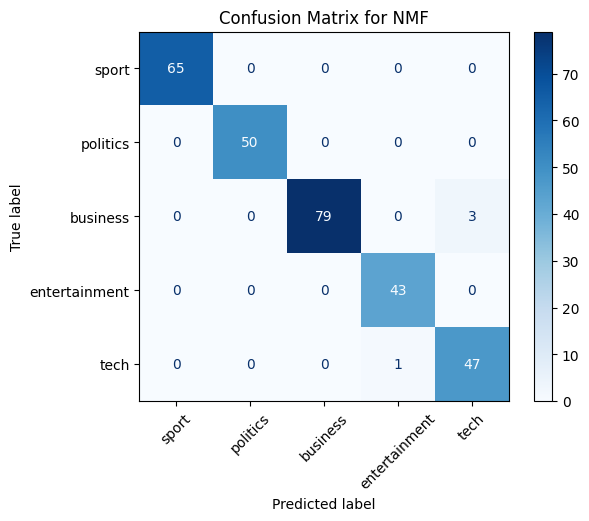

In [118]:
cm = confusion_matrix(y_val, y_pred, labels=list(topic_mapping.values()))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(topic_mapping.values()))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for NMF")

In [121]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('model', SVC(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = [
    {
    'model': [SVC(random_state=42)],
    'tfidf__max_df': [0.8, 1.0],
    'tfidf__min_df': [1, 5],
    'tfidf__ngram_range': [(1, 1), (1, 3)],
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear']
    },
    {
    'model': [LogisticRegression(random_state=42)],
    'tfidf__max_df': [0.8, 1.0],
    'tfidf__min_df': [1, 5],
    'tfidf__ngram_range': [(1, 1), (1, 3)],
    'model__penalty': ['l2'],
    'model__C': [0.1, 1, 10],
    'model__solver': ['lbfgs', 'liblinear'],
    'model__max_iter': [500]
    }
]
# Store results for comparison
results = []

# Define percentages of training data to use
percentages = [0.1, 0.2, 0.5, 1.0]

for pct in percentages:
    print(f"Training with {int(pct * 100)}% of the data...")

    # Create a subset of the training data
    if pct == 1.0:
        X_subset, y_subset = X_train, y_train
    else:
        X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=pct, stratify=y_train, random_state=42)

    # Grid search on the subset
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,  # 3-fold cross-validation
        verbose=1
    )
    grid_search.fit(X_subset, y_subset)

    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    cv_results_df['percentage'] = pct  # Add a column for percentage

    results.append(cv_results_df)

# Combine all results into a single DataFrame
final_results_df = pd.concat(results, ignore_index=True)

# Display or save the final results DataFrame
final_results_df.head()

Training with 10% of the data...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Training with 20% of the data...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Training with 50% of the data...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Training with 100% of the data...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__kernel,param_tfidf__max_df,param_tfidf__min_df,param_tfidf__ngram_range,...,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
0,0.100128,0.088056,0.012931,0.000970,SVC(random_state=42),0.1,linear,0.8,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 0....",0.230769,0.263158,0.236842,0.24359,0.014057,65,0.1
1,0.130348,0.001900,0.022922,0.001307,SVC(random_state=42),0.1,linear,0.8,1,"(1, 3)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 0....",0.230769,0.263158,0.236842,0.24359,0.014057,65,0.1
2,0.024971,0.000650,0.009539,0.000374,SVC(random_state=42),0.1,linear,0.8,5,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 0....",0.230769,0.263158,0.236842,0.24359,0.014057,65,0.1
3,0.059482,0.001968,0.017067,0.000590,SVC(random_state=42),0.1,linear,0.8,5,"(1, 3)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 0....",0.230769,0.263158,0.236842,0.24359,0.014057,65,0.1
4,0.034932,0.001374,0.012656,0.001886,SVC(random_state=42),0.1,linear,1.0,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 0....",0.230769,0.263158,0.236842,0.24359,0.014057,65,0.1


In [122]:
final_results_data_10_pct = final_results_df[final_results_df['percentage'] == 0.1]
final_results_data_10_pct.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__kernel,param_tfidf__max_df,param_tfidf__min_df,param_tfidf__ngram_range,...,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
16,0.042099,0.010762,0.013829,0.002761,SVC(random_state=42),10.0,linear,0.8,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 10...",0.846154,0.868421,1.000000,0.904858,0.067887,1,0.1
20,0.053891,0.003137,0.018067,0.000751,SVC(random_state=42),10.0,linear,1.0,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 10...",0.846154,0.868421,1.000000,0.904858,0.067887,1,0.1
12,0.036484,0.000251,0.012039,0.000349,SVC(random_state=42),1.0,linear,1.0,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 1,...",0.846154,0.868421,1.000000,0.904858,0.067887,1,0.1
8,0.035196,0.001583,0.011409,0.000307,SVC(random_state=42),1.0,linear,0.8,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 1,...",0.846154,0.868421,1.000000,0.904858,0.067887,1,0.1
60,0.507776,0.052526,0.024101,0.011275,LogisticRegression(random_state=42),10.0,NaN,1.0,1,"(1, 1)",...,l2,lbfgs,"{'model': LogisticRegression(random_state=42),...",0.846154,0.868421,0.973684,0.896086,0.055618,5,0.1


In [123]:
final_results_data_20_pct = final_results_df[final_results_df['percentage'] == 0.2]
final_results_data_20_pct.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__kernel,param_tfidf__max_df,param_tfidf__min_df,param_tfidf__ngram_range,...,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
136,0.046357,0.001552,0.014955,0.000656,LogisticRegression(random_state=42),10.0,NaN,0.8,1,"(1, 1)",...,l2,liblinear,"{'model': LogisticRegression(random_state=42),...",0.961039,0.974026,0.894737,0.943267,0.034723,1,0.2
140,0.045115,0.000974,0.014047,0.000420,LogisticRegression(random_state=42),10.0,NaN,1.0,1,"(1, 1)",...,l2,liblinear,"{'model': LogisticRegression(random_state=42),...",0.961039,0.974026,0.894737,0.943267,0.034723,1,0.2
132,0.663529,0.160475,0.049998,0.006957,LogisticRegression(random_state=42),10.0,NaN,1.0,1,"(1, 1)",...,l2,lbfgs,"{'model': LogisticRegression(random_state=42),...",0.961039,0.974026,0.894737,0.943267,0.034723,1,0.2
128,0.507132,0.085102,0.033768,0.014451,LogisticRegression(random_state=42),10.0,NaN,0.8,1,"(1, 1)",...,l2,lbfgs,"{'model': LogisticRegression(random_state=42),...",0.961039,0.974026,0.894737,0.943267,0.034723,1,0.2
88,0.095638,0.000555,0.030049,0.000786,SVC(random_state=42),10.0,linear,0.8,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 10...",0.961039,0.974026,0.894737,0.943267,0.034723,1,0.2


In [124]:
final_results_data_50_pct = final_results_df[final_results_df['percentage'] == 0.5]
final_results_data_50_pct.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__kernel,param_tfidf__max_df,param_tfidf__min_df,param_tfidf__ngram_range,...,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
160,0.410068,0.007617,0.122571,0.002388,SVC(random_state=42),10.0,linear,0.8,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 10...",0.953125,0.973958,0.979167,0.968750,0.011251,1,0.5
164,0.421396,0.002561,0.125343,0.003475,SVC(random_state=42),10.0,linear,1.0,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 10...",0.953125,0.973958,0.979167,0.968750,0.011251,1,0.5
152,0.570506,0.013840,0.163618,0.011556,SVC(random_state=42),1.0,linear,0.8,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 1,...",0.953125,0.973958,0.979167,0.968750,0.011251,1,0.5
156,0.421602,0.005573,0.126883,0.002729,SVC(random_state=42),1.0,linear,1.0,1,"(1, 1)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 1,...",0.947917,0.973958,0.979167,0.967014,0.013670,4,0.5
208,0.138458,0.019747,0.060500,0.001777,LogisticRegression(random_state=42),10.0,NaN,0.8,1,"(1, 1)",...,l2,liblinear,"{'model': LogisticRegression(random_state=42),...",0.942708,0.973958,0.973958,0.963542,0.014731,5,0.5


In [125]:
final_results_data_100_pct = final_results_df[final_results_df['percentage'] == 1.0]
final_results_data_100_pct.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__kernel,param_tfidf__max_df,param_tfidf__min_df,param_tfidf__ngram_range,...,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,percentage
237,4.266302,0.258557,0.912755,0.137300,SVC(random_state=42),10.0,linear,1.0,1,"(1, 3)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 10...",0.984375,0.968750,0.968750,0.973958,0.007366,1,1.0
229,4.375198,0.612405,0.825989,0.003229,SVC(random_state=42),1.0,linear,1.0,1,"(1, 3)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 1,...",0.984375,0.968750,0.968750,0.973958,0.007366,1,1.0
225,4.351792,0.555288,0.796276,0.007745,SVC(random_state=42),1.0,linear,0.8,1,"(1, 3)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 1,...",0.981771,0.968750,0.968750,0.973090,0.006138,3,1.0
233,4.620564,0.470160,0.909281,0.141025,SVC(random_state=42),10.0,linear,0.8,1,"(1, 3)",...,NaN,NaN,"{'model': SVC(random_state=42), 'model__C': 10...",0.981771,0.968750,0.968750,0.973090,0.006138,3,1.0
277,10.979294,1.746115,0.256178,0.054809,LogisticRegression(random_state=42),10.0,NaN,1.0,1,"(1, 3)",...,l2,lbfgs,"{'model': LogisticRegression(random_state=42),...",0.981771,0.971354,0.966146,0.973090,0.006496,3,1.0


In [160]:
best_supervised_model = grid_search.best_estimator_

In [159]:
y_pred = best_supervised_model.predict(X_val)
acc = np.mean(y_val == y_pred)
print("Accuracy Validation Dataset:", acc)

Accuracy Validation Dataset: 0.9756944444444444


測試集資料表現

In [161]:
X_test = test_data['Text_Preprocess']

In [152]:
pred_test = best_unsupervised_model.transform(X_test)
y_pred_test = np.argmax(pred_test, axis=1)

y_pred = [topic_mapping[topic] for topic in y_pred_test]

submission_nmf = pd.DataFrame({
    'ArticleId': test_data['ArticleId'],
    'Category': y_pred
})
submission.to_csv('submission_nmf.csv', index=False)

In [153]:
y_pred_test = best_supervised_model.predict(X_test)

submission_svc = pd.DataFrame({
    'ArticleId': test_data['ArticleId'],
    'Category': y_pred_test
})
submission.to_csv('submission_svc.csv', index=False)

支援向量機在測試集資料準確率為0.97823。

矩陣分解在測試集資料準確率為0.96326。

### 結論

- 資料效率：監督式方法如 SVC 直接利用標註資料來學習類別之間的決策邊界，這使得它在有足夠標註資料的情況下能夠做出更好的預測。相對而言，NMF 作為一種非監督式技術，並不直接使用標註資訊，通常更適用於像是特徵提取或降維等任務。

- 穩健性：SVC 對高維特徵空間具有很好的穩健性，這對於處理像 BBC News 這樣的文本分類任務相對重要，因為文本資料的特徵（詞彙）數量可能非常龐大。SVC 能夠有效處理這種高維空間並保持較好的泛化能力。然而，NMF 可能在穩健性上有所不足，因為它假設資料可以被分解成非負組件，這並不總是能夠捕捉到分類所需的底層結構。

- 準確率高：由於 SVC 是從標註資料中學習，因此在分類任務中通常能提供更準確的結果，因為它明確地學習了類別之間的決策邊界。相對的，NMF 更偏向於探索性，並未明確學習分類模型，這使得它在監督式任務中的效果相對較差，儘管它對於揭示資料中的潛在主題或結構非常有用。